Initializing Packages

In [273]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci
import scipy.stats as scistats
from mcareader import Mca
import scipy.signal as fp
import os
import re

Section 1: Loading in the data and storing it as lists

In [274]:
def extract_mca_data(file_path):
    data_values = []
    inside_data_section = False

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line == "<<DATA>>":
                inside_data_section = True
                continue
            if line == "<<END>>":
                break
            if inside_data_section and line.isdigit():
                data_values.append(int(line))
    return data_values

In [275]:
directory = "team_battery"

# Regex: ba_<gain>_<voltage>.mca  e.g. ba_4_1659.mca
pattern = re.compile(r"ba_(\d+)_(\d+)\.mca")

# Temporary storage: (gain, voltage, data_list)
temp_storage = []

for filename in os.listdir(directory):
    match = pattern.search(filename)
    if match:
        gain = float(match.group(1))      # first number
        voltage = float(match.group(2))   # second number
        file_path = os.path.join(directory, filename)
        data = extract_mca_data(file_path)
        temp_storage.append((gain, voltage, data))

# Sort by gain, then by voltage (both ascending)
temp_storage.sort(key=lambda item: (item[0], item[1]))  # multi-key sort [web:45][web:47]

# Split into separate lists
file_gains     = [item[0] for item in temp_storage]
file_labels  = [item[1] for item in temp_storage]
all_data_lists = [item[2] for item in temp_storage]

print(f"Loaded {len(all_data_lists)} files in ascending order of gain, then voltage.\n")

# Print gain and voltage for each file
for i, (g, v) in enumerate(zip(file_gains, file_labels), start=1):
    print(f"File {i}: gain = {g}, voltage = {v}")

Loaded 22 files in ascending order of gain, then voltage.

File 1: gain = 2.0, voltage = 2168.0
File 2: gain = 2.0, voltage = 2228.0
File 3: gain = 2.0, voltage = 2288.0
File 4: gain = 2.0, voltage = 2348.0
File 5: gain = 4.0, voltage = 2048.0
File 6: gain = 4.0, voltage = 2108.0
File 7: gain = 4.0, voltage = 2168.0
File 8: gain = 10.0, voltage = 1928.0
File 9: gain = 10.0, voltage = 1988.0
File 10: gain = 10.0, voltage = 2048.0
File 11: gain = 20.0, voltage = 1748.0
File 12: gain = 20.0, voltage = 1808.0
File 13: gain = 20.0, voltage = 1868.0
File 14: gain = 20.0, voltage = 1928.0
File 15: gain = 40.0, voltage = 1568.0
File 16: gain = 40.0, voltage = 1628.0
File 17: gain = 40.0, voltage = 1688.0
File 18: gain = 40.0, voltage = 1748.0
File 19: gain = 100.0, voltage = 1388.0
File 20: gain = 100.0, voltage = 1448.0
File 21: gain = 100.0, voltage = 1508.0
File 22: gain = 100.0, voltage = 1568.0


In [276]:
# # --------- CONFIG ---------
# directory = "team_battery"

# # Example filename: ba_<gain>_<voltage>.mca (supports integers/decimals)
# pattern = re.compile(r"ba_(\d+(?:\.\d+)?)_(\d+(?:\.\d+)?)\.mca")

# # --------- YOUR DATA EXTRACTOR ---------
# def extract_mca_data(file_path):
#     """
#     Replace this stub with your actual .mca parser.
#     """
#     # Demo placeholder:
#     return {"path": file_path}

# # --------- COLLECT FILES (KEEP FIELDS TOGETHER) ---------
# # We'll keep items as tuples: (gain, voltage, data, filename)
# records = []

# for filename in os.listdir(directory):
#     m = pattern.fullmatch(filename)  # use .search(...) if names vary
#     if not m:
#         continue

#     gain = float(m.group(1))
#     voltage = float(m.group(2))
#     file_path = os.path.join(directory, filename)

#     data = extract_mca_data(file_path)
#     records.append((gain, voltage, data, filename))

# # --------- SORT: voltage ASC, gain DESC ---------
# # Key: (voltage, -gain) so within each voltage, gains are descending.
# records.sort(key=lambda t: (t[1], -t[0]))

# # --------- UNPACK INTO SEPARATE LISTS (AFTER SORT) ---------
# file_gains    = [t[0] for t in records]
# file_voltages = [t[1] for t in records]
# all_data      = [t[2] for t in records]
# file_names    = [t[3] for t in records]  # optional

# # --------- OUTPUT ---------
# print(f"Loaded {len(records)} files. Ordered by voltage ↑ then gain ↓.\n")
# for i, (g, v, _, name) in enumerate(records, start=1):
#     print(f"File {i}: voltage = {v}, gain = {g}  ({name})")


In [277]:
bkg=extract_mca_data('team_battery/bkg_10_1789.mca')
# Initialising the background
channel_no=np.linspace(0,len(all_data_lists[0]),1024)

In [278]:
def gaussian(x, a, mu, sigma):
    return a*np.exp(-(x - mu)**2 / (2 * sigma**2))
#defining the gaussian

Creating functions to run withing loops (The names are self explainatory)

In [279]:
def bkg_corrector(bkg_list,data_list,index):
    bkg_corr_data_list=[]
    for i in range(0,len(bkg_list)):
        bkg_corr_data=data_list[index][i]-bkg_list[i]
        bkg_corr_data_list.append(bkg_corr_data)
    bkg_corr_data_list=np.array(bkg_corr_data_list).clip(min=0)
    return bkg_corr_data_list

In [280]:
def peak_fitter(function, channel, data_list,fit_range,init_guess):
    mu, cov=sci.curve_fit(function,channel[fit_range[0]:fit_range[1]],data_list[fit_range[0]:fit_range[1]],p0=init_guess,maxfev=3000)
    gauss=gaussian(channel[fit_range[0]:fit_range[1]],*mu)
    channel_no_ranged=channel[fit_range[0]:fit_range[1]]
    return channel_no_ranged, gauss, mu, cov

In [281]:
def peak_scouter(index,
                 minimum_expected_peak_height,
                 minimum_bin_distance_between_peaks,
                 minimum_peak_width,
                 maximum_peak_width,
                 minimum_peak_prominence,
                 bkg,
                 all_data_lists):

    peak_pnts = []
    range_list = []
    p0_list = []
    bkg_corr_ind = bkg_corrector(bkg, all_data_lists, index)
    
    # Find all peaks
    peaks, properties = fp.find_peaks(
        bkg_corr_ind,
        height=minimum_expected_peak_height,
        distance=minimum_bin_distance_between_peaks,
        width=(minimum_peak_width, maximum_peak_width),
        prominence=minimum_peak_prominence,
        rel_height=0.5
    )
    
    peak_bins = peaks
    peak_heights = properties["peak_heights"]
    peak_positions = channel_no[peak_bins]
    peak_widths = properties["widths"]
    
    # ---- keep ONLY the single highest peak ----
    if len(peak_heights) > 0:
        top_idx = np.argmax(peak_heights)      # index of max height
        peak_bins = peak_bins[top_idx:top_idx+1]
        peak_heights = peak_heights[top_idx:top_idx+1]
        peak_positions = peak_positions[top_idx:top_idx+1]
        peak_widths = peak_widths[top_idx:top_idx+1]
    # -------------------------------------------

    print("Rough peak positions:", peak_positions)
    print("NO. PEAKS DETECTED:", len(peak_positions))
    print("Peak heights:", peak_heights)
    
    for i in peak_bins:
        peak_pnts.append(bkg_corr_ind[i])
    
    for i in range(len(peak_bins)):  # now at most 1
        # default auto range from width
        lower_lim = peak_bins[i] - 2 * peak_widths[i]
        upper_lim = peak_bins[i] + 2 * peak_widths[i]
        fit_range = [int(lower_lim + 1), int(upper_lim + 1)]

        # --- custom range ONLY for the third graph (index == 2) ---
        # replace [300, 420] with your desired channel window
        if index == 3:
            fit_range = [650, 1000]
        # ----------------------------------------------------------

        range_list.append(fit_range)
        
        a_est = peak_heights[i]
        mu_est = peak_positions[i]
        sigma_est = peak_widths[i]
        init_guess = [a_est, mu_est, sigma_est]
        p0_list.append(init_guess)
    
    return peak_pnts, peak_bins, peak_positions, peak_widths, range_list, p0_list, bkg_corr_ind


In [282]:

# # NO THRESHOLD - MODIFIED TO DETECT ONLY 2 HIGHEST PEAKS
# def peak_scouter(index, minimum_expected_peak_height, minimum_bin_distance_between_peaks, minimum_peak_width, maximum_peak_width, minimum_peak_prominence, bkg, all_data_lists):
#     peak_pnts = []
#     range_list = []
#     p0_list = []
#     bkg_corr_ind = bkg_corrector(bkg, all_data_lists, index)
    
#     # Find all peaks first
#     peaks, properties = fp.find_peaks(
#         bkg_corr_ind,
#         height=minimum_expected_peak_height,   # Filter noise, set to a value below expected peaks
#         distance=minimum_bin_distance_between_peaks,  # To avoid detecting overlapping peaks
#         width=(minimum_peak_width, maximum_peak_width),   # Accept variable peak widths
#         prominence=minimum_peak_prominence,    # For sharper peaks, avoids flat humps
#         rel_height=0.5
#     )
    
#     peak_bins = peaks
#     peak_heights = properties["peak_heights"]
#     peak_positions = channel_no[peak_bins]
#     peak_widths = properties["widths"]
    
#     # Sort peaks by height (descending order) and take only the top 2
#     if len(peak_heights) > 1:
#         # Get indices of the 2 highest peaks
#         top_indices = np.argsort(peak_heights)[-1:][::-1]  # [::-1] to get descending order
        
#         # Keep only the top 2 peaks
#         peak_bins = peak_bins[top_indices]
#         peak_heights = peak_heights[top_indices]
#         peak_positions = peak_positions[top_indices]
#         peak_widths = peak_widths[top_indices]
    
#     print("Rough peak positions:", peak_positions)
#     print("NO. PEAKS DETECTED:", len(peak_positions))
#     print("Peak heights:", peak_heights)
    
#     for i in peak_bins:
#         peak_ind = bkg_corr_ind[i]
#         peak_pnts.append(peak_ind)
        
#     for i in range(len(peak_bins)):
#         lower_lim = peak_bins[i] - 2 * peak_widths[i]
#         upper_lim = peak_bins[i] + 2 * peak_widths[i] 
#         fit_range = [int(lower_lim + 1), int(upper_lim + 1)]
#         range_list.append(fit_range)
        
#         a_est = peak_heights[i]
#         mu_est = peak_positions[i]
#         sigma_est = peak_widths[i]
#         init_guess = [a_est, mu_est, sigma_est]
#         p0_list.append(init_guess)
        
#     return peak_pnts, peak_bins, peak_positions, peak_widths, range_list, p0_list, bkg_corr_ind

In [283]:
def graphfitter(range_list,num_peak,function,channels,bkg_corr_data,p0_list):
    ranged_channel_list=[]
    fit_gauss_list=[]
    for peak_num in num_peak:
        for peaks in range(0,peak_num-1):
            ranged_channel,fit_gauss,mu,cov = peak_fitter(function,channels,bkg_corr_data,range_list[peaks],p0_list[peaks])
            ranged_channel_list.append(ranged_channel)
            fit_gauss_list.append(fit_gauss)
            centroid_error=np.sqrt(np.diag(cov))
            print(f"The fitting range for peak {peaks}:",ranged_channel[0],ranged_channel[-1])
            print(f"The centroid for peak {peaks}:",mu[1])
            print(f"The error on the centroid fit for peak {peaks}:", centroid_error[1])
        return ranged_channel_list, fit_gauss_list

In [284]:
index=3
minimum_expected_peak_height=40
minimum_bin_distance_between_peaks=100
minimum_peak_width=8
maximum_peak_width=200
minimum_peak_prominence=None
# threshold=13

channel_no=np.linspace(0,len(all_data_lists[index]),1024)

In [285]:
def graphfitter(range_list,function,channels,bkg_corr_data,p0_list):
    ranged_channel_list=[]
    fit_gauss_list=[]
    for peaks in range(0,len(range_list)):
        ranged_channel,fit_gauss,mu,cov  = peak_fitter(function,channels,bkg_corr_data,range_list[peaks],p0_list[peaks])
        ranged_channel_list.append(ranged_channel)
        fit_gauss_list.append(fit_gauss)
        centroid_error=np.sqrt(np.diag(cov))
        print(f"The fitting range for peak {peaks}:",ranged_channel[0],ranged_channel[-1])
        print(f"The centroid for peak {peaks}:",mu[1])
        print(f"The error on the centroid fit for peak {peaks}:", centroid_error[1])
    return ranged_channel_list, fit_gauss_list

Test section to fit and run per voltage fits

In [286]:
peak_pnts, peak_bins, peak_positions, peak_width, range_list, p0_list, bkg_corr_ind  =  peak_scouter(index,minimum_expected_peak_height,minimum_bin_distance_between_peaks,minimum_peak_width,maximum_peak_width,minimum_peak_prominence,bkg,all_data_lists)

Rough peak positions: [818.79960899]
NO. PEAKS DETECTED: 1
Peak heights: [46.]


In [287]:
ranged_channel_list,fit_gauss_list = graphfitter(range_list,gaussian,channel_no,bkg_corr_ind,p0_list)

The fitting range for peak 0: 650.6353861192571 999.9765395894428
The centroid for peak 0: 809.7120363185576
The error on the centroid fit for peak 0: 0.9747211098235263


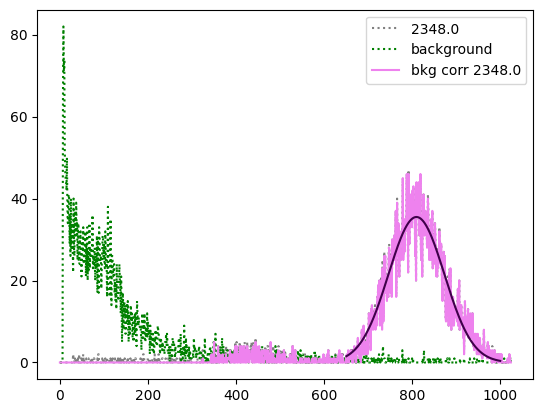

Initial guess list [[np.float64(46.0), np.float64(818.7996089931573), np.float64(13.741666666666674)]]
Fitting range for each peak [[650, 1000]]


In [288]:
#plotting the curve and the peaks (Still working on the automatic fitting, worst case scenario we can just manually fit the curves)
peakcolors=len(ranged_channel_list)
peaklegend=plt.cm.PRGn(np.linspace(0,1,peakcolors))
fig, ax = plt.subplots()
ax.plot(channel_no,all_data_lists[index],label=file_labels[index],color='grey',linestyle='dotted')
ax.plot(channel_no,bkg,label='background',color='green',linestyle='dotted')
ax.plot(channel_no,bkg_corr_ind,label=f'bkg corr {file_labels[index]}',color='violet')
# ax.plot(peak_positions,peak_pnts,'r.')
for fitpeak in range(0,len(ranged_channel_list)):
    ax.plot(ranged_channel_list[fitpeak],fit_gauss_list[fitpeak],color=peaklegend[fitpeak])
ax.legend()
# plt.xlim(0,200)
plt.show()
print("Initial guess list",p0_list)
print("Fitting range for each peak",range_list)




Trying a loop to fit all the possible peaks for bias voltage

In [289]:
for bias_voltage in range(0,len(all_data_lists)):
    print("BIAS VOLTAGE",file_labels[bias_voltage],": Index",bias_voltage)
    peak_pnts, peak_bins, peak_positions, peak_width, range_list, p0_list,bkg_corr_ind  =  peak_scouter(bias_voltage,minimum_expected_peak_height,minimum_bin_distance_between_peaks,minimum_peak_width,maximum_peak_width,minimum_peak_prominence,bkg,all_data_lists)
    # graphfitter(range_list,gaussian,channel_no,bkg_corr_ind,p0_list)
    

BIAS VOLTAGE 2168.0 : Index 0
Rough peak positions: [202.19745846]
NO. PEAKS DETECTED: 1
Peak heights: [146.]
BIAS VOLTAGE 2228.0 : Index 1
Rough peak positions: [303.29618768]
NO. PEAKS DETECTED: 1
Peak heights: [104.]
BIAS VOLTAGE 2288.0 : Index 2
Rough peak positions: [523.51124145]
NO. PEAKS DETECTED: 1
Peak heights: [66.]
BIAS VOLTAGE 2348.0 : Index 3
Rough peak positions: [818.79960899]
NO. PEAKS DETECTED: 1
Peak heights: [46.]
BIAS VOLTAGE 2048.0 : Index 4
Rough peak positions: [163.15933529]
NO. PEAKS DETECTED: 1
Peak heights: [180.]
BIAS VOLTAGE 2108.0 : Index 5
Rough peak positions: [249.24340176]
NO. PEAKS DETECTED: 1
Peak heights: [120.]
BIAS VOLTAGE 2168.0 : Index 6
Rough peak positions: [404.39491691]
NO. PEAKS DETECTED: 1
Peak heights: [90.]
BIAS VOLTAGE 1928.0 : Index 7
Rough peak positions: [156.15249267]
NO. PEAKS DETECTED: 1
Peak heights: [175.]
BIAS VOLTAGE 1988.0 : Index 8
Rough peak positions: [251.24535679]
NO. PEAKS DETECTED: 1
Peak heights: [121.]
BIAS VOLTAGE 

Final Histogram plotting


Processing bias voltage 2168.0 (Index 0)
Rough peak positions: [202.19745846]
NO. PEAKS DETECTED: 1
Peak heights: [146.]

Fitting peaks for bias voltage 2168.0:
  Peak 1: Centroid = 201.872 ± 0.282
✓ Successfully fitted 1 peaks

Processing bias voltage 2228.0 (Index 1)
Rough peak positions: [303.29618768]
NO. PEAKS DETECTED: 1
Peak heights: [104.]

Fitting peaks for bias voltage 2228.0:
  Peak 1: Centroid = 317.803 ± 0.399
✓ Successfully fitted 1 peaks

Processing bias voltage 2288.0 (Index 2)
Rough peak positions: [523.51124145]
NO. PEAKS DETECTED: 1
Peak heights: [66.]

Fitting peaks for bias voltage 2288.0:
  Peak 1: Centroid = 509.651 ± 0.672
✓ Successfully fitted 1 peaks

Processing bias voltage 2348.0 (Index 3)
Rough peak positions: [818.79960899]
NO. PEAKS DETECTED: 1
Peak heights: [46.]

Fitting peaks for bias voltage 2348.0:
  Peak 1: Centroid = 809.712 ± 0.975
✓ Successfully fitted 1 peaks

Processing bias voltage 2048.0 (Index 4)
Rough peak positions: [163.15933529]
NO. PEA

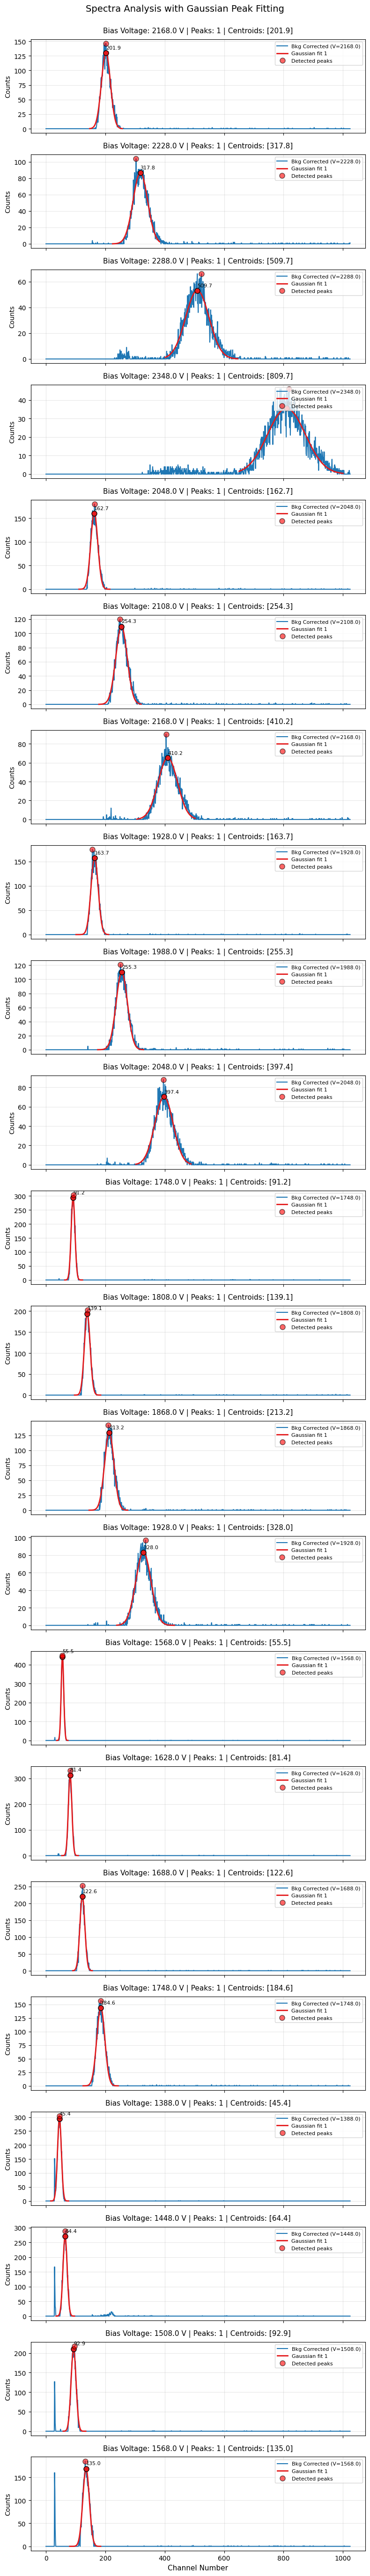


PROCESSING SUMMARY
Total spectra processed: 22
Total peaks fitted: 22

CENTROID SUMMARY

Spectrum 0 (Bias Voltage: 2168.0):
  Peak 1: Centroid = 201.872 ± 0.282

Spectrum 1 (Bias Voltage: 2228.0):
  Peak 1: Centroid = 317.803 ± 0.399

Spectrum 2 (Bias Voltage: 2288.0):
  Peak 1: Centroid = 509.651 ± 0.672

Spectrum 3 (Bias Voltage: 2348.0):
  Peak 1: Centroid = 809.712 ± 0.975

Spectrum 4 (Bias Voltage: 2048.0):
  Peak 1: Centroid = 162.653 ± 0.206

Spectrum 5 (Bias Voltage: 2108.0):
  Peak 1: Centroid = 254.271 ± 0.300

Spectrum 6 (Bias Voltage: 2168.0):
  Peak 1: Centroid = 410.208 ± 0.548

Spectrum 7 (Bias Voltage: 1928.0):
  Peak 1: Centroid = 163.730 ± 0.210

Spectrum 8 (Bias Voltage: 1988.0):
  Peak 1: Centroid = 255.264 ± 0.285

Spectrum 9 (Bias Voltage: 2048.0):
  Peak 1: Centroid = 397.365 ± 0.490

Spectrum 10 (Bias Voltage: 1748.0):
  Peak 1: Centroid = 91.229 ± 0.111

Spectrum 11 (Bias Voltage: 1808.0):
  Peak 1: Centroid = 139.104 ± 0.168

Spectrum 12 (Bias Voltage: 1868.0

In [290]:
def plot_all_spectra_with_fits(all_data_lists, bkg, file_labels):
    n = len(all_data_lists)
    fig, axes = plt.subplots(n, 1, figsize=(8, 2.5*n), sharex=True)
    if n == 1:
        axes = [axes]

    all_fit_ranges = []
    all_fit_results = []
    all_centroids = []        # per-spectrum centroids
    all_centroid_errors = []  # per-spectrum errors

    for idx in range(n):
        print(f"\n{'='*50}")
        print(f"Processing bias voltage {file_labels[idx]} (Index {idx})")
        print(f"{'='*50}")
        ax = axes[idx]

        bkg_corr = bkg_corrector(bkg, all_data_lists, idx)

        (peak_pnts, peak_bins, peak_positions,
         peak_width, range_list, p0_list, bkg_corr_ind) = peak_scouter(
            idx,
            minimum_expected_peak_height,
            minimum_bin_distance_between_peaks,
            minimum_peak_width,
            maximum_peak_width,
            minimum_peak_prominence,
            bkg,
            all_data_lists
        )

        this_fit_ranges = [[float(r[0]), float(r[1])] for r in range_list]
        all_fit_ranges.append(this_fit_ranges)
        
        ax.plot(channel_no, bkg_corr, label=f"Bkg Corrected (V={file_labels[idx]})",
                color="C0", linewidth=1.5)

        spectrum_centroids = []
        spectrum_centroid_errors = []

        if len(peak_positions) > 0:
            print(f"\nFitting peaks for bias voltage {file_labels[idx]}:")
            
            spectrum_fit_results = []
            ranged_channel_list = []
            fit_gauss_list = []
            
            for i, (fit_range, init_guess) in enumerate(zip(range_list, p0_list)):
                ranged_channel, fit_gauss, mu, cov = peak_fitter(
                    gaussian, channel_no, bkg_corr_ind, fit_range, init_guess
                )
                
                centroid = mu[1]
                centroid_error = np.sqrt(np.diag(cov))[1]
                
                spectrum_centroids.append(centroid)
                spectrum_centroid_errors.append(centroid_error)
                
                ranged_channel_list.append(ranged_channel)
                fit_gauss_list.append(fit_gauss)
                
                print(f"  Peak {i+1}: Centroid = {centroid:.3f} ± {centroid_error:.3f}")
            
            all_centroids.append(spectrum_centroids)
            all_centroid_errors.append(spectrum_centroid_errors)
            
            for i, (ranged_channel, fit_gauss) in enumerate(zip(ranged_channel_list, fit_gauss_list)):
                spectrum_fit_results.append({
                    'channel_range': [ranged_channel[0], ranged_channel[-1]],
                    'fitted_gaussian': fit_gauss,
                    'centroid': spectrum_centroids[i],
                    'centroid_error': spectrum_centroid_errors[i]
                })
            all_fit_results.append(spectrum_fit_results)

            colors = plt.cm.Set1(np.linspace(0, 1, len(fit_gauss_list)))
            for i, (ranged_channel, fit_gauss, color) in enumerate(zip(ranged_channel_list, fit_gauss_list, colors)):
                ax.plot(ranged_channel, fit_gauss, color=color, linewidth=2, 
                        label=f'Gaussian fit {i+1}' if i < 5 else '')
                
                centroid = spectrum_centroids[i]
                fit_max = np.max(fit_gauss)
                ax.plot(centroid, fit_max, 'o', color=color, markersize=8, 
                        markeredgecolor='black', markeredgewidth=1)
                
                ax.text(centroid, fit_max + fit_max*0.05, f'{centroid:.1f}', 
                        fontsize=8, ha='left', color='black')

        for bin_idx, peak_height in zip(peak_bins, peak_pnts):
            x = channel_no[bin_idx]
            y = peak_height
            ax.plot(x, y, "ro", markersize=8, alpha=0.6, markeredgecolor='black', 
                    label='Detected peaks' if bin_idx == peak_bins[0] else '')

        ax.set_ylabel("Counts", fontsize=10)
        
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc="upper right", fontsize=8)
        
        title = f"Bias Voltage: {file_labels[idx]} V | Peaks: {len(peak_positions)}"
        if len(peak_positions) > 0 and spectrum_centroids:
            centroids_str = ', '.join([f'{c:.1f}' for c in spectrum_centroids])
            title += f" | Centroids: [{centroids_str}]"
        
        ax.set_title(title, fontsize=11, pad=10)
        ax.grid(True, alpha=0.3)

        print(f"✓ Successfully fitted {len(spectrum_centroids)} peaks")

    axes[-1].set_xlabel("Channel Number", fontsize=11)
    plt.suptitle("Spectra Analysis with Gaussian Peak Fitting", fontsize=14, y=1)
    plt.tight_layout()
    plt.show()

    print(f"\n{'='*60}")
    print("PROCESSING SUMMARY")
    print(f"{'='*60}")
    total_peaks = sum(len(c) for c in all_centroids)
    print(f"Total spectra processed: {n}")
    print(f"Total peaks fitted: {total_peaks}")
    
    print(f"\n{'='*60}")
    print("CENTROID SUMMARY")
    print(f"{'='*60}")
    for idx, (centroids, errors) in enumerate(zip(all_centroids, all_centroid_errors)):
        print(f"\nSpectrum {idx} (Bias Voltage: {file_labels[idx]}):")
        for i, (c, e) in enumerate(zip(centroids, errors)):
            print(f"  Peak {i+1}: Centroid = {c:.3f} ± {e:.3f}")
    
    print(f"\n{'='*60}")
    print("CENTROIDS ONLY (for easy copying):")
    print(f"{'='*60}")
    print("all_centroids = [")
    for idx, centroids in enumerate(all_centroids):
        if centroids:
            centroid_list = [f"{c:.3f}" for c in centroids]
            print(f"    # Spectrum {idx} (V={file_labels[idx]}): {centroid_list},")
        else:
            print(f"    # Spectrum {idx} (V={file_labels[idx]}): [],")
    print("]")

    # NEW: flatten to 1D arrays
    flat_centroids = np.array([c for spec in all_centroids for c in spec])
    flat_centroid_errors = np.array([e for spec in all_centroid_errors for e in spec])

    return all_fit_ranges,all_fit_results,all_centroids,all_centroid_errors,flat_centroids,flat_centroid_errors

# Updated call:
fit_ranges,fit_results,all_centroids,all_centroid_errors,flat_centroids,flat_centroid_errors = plot_all_spectra_with_fits(all_data_lists, bkg, file_labels)


In [291]:
def energy_cali(channels):
    energy_list=[]
    for i in range(0,len(channels)):
        energy=0.1040*(channels[i]) - 0.4074
        if energy>0:
            energy_list.append(energy)
    return energy_list

In [292]:
numline=len(all_data_lists)
colour=plt.cm.plasma(np.linspace(0,1,numline))

In [293]:
# def hist_generator_bkg_corrected(index,data_list,bkg,label_list,color):
#     bkg_correction=bkg_corrector(bkg,data_list,index)
#     # plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index])
#     plt.plot(np.linspace(0,len(data_list[index]),1024),bkg_correction,label=f"corrected {label_list[index]}",color=color)
#     # plt.xlim(0,100)
#     plt.title("Ba133 Combined Histograms (Background corrected)")
#     plt.xlabel("Channel Number")
#     plt.ylabel("Counts")
#     # plt.axline([0,200],slope=0,color='black',linestyle='dashed',linewidth=0.7)
#     plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))


In [294]:
# def hist_generator(index,data_list,label_list,color):
#     plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index],color=color)
#     # plt.axline([0,30],slope=0,color='black',linestyle='dashed',linewidth=0.7)
#     # plt.xlim(0,100)
#     plt.title("Fe55 Combined Histograms (No background correction)")
#     plt.xlabel("Channel Number")
#     plt.ylabel("Counts")
#     plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))

In [295]:
def hist_generator(index,data_list,bkg,label_list,color,channels):
    # bkg_correction=bkg_corrector(bkg,data_list,index)
    # plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index])
    energy_list=energy_cali(channels)
    plt.plot(energy_list,all_data_lists[index][-(len(energy_list)):],label=f"{label_list[index]}",color=color)
    # plt.xlim(0,100)
    # plt.axline([0,200],slope=0,color='black',linestyle='dashed',linewidth=0.7)
    plt.title("Ba133 Combined Histograms")
    plt.xlabel("Energy (KeV)")
    plt.ylabel("Counts")
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))
    plt.grid(True, linestyle=':')


In [296]:
def hist_generator_bkg_corrected(index,data_list,bkg,label_list,color,channels):
    bkg_correction=bkg_corrector(bkg,data_list,index)
    # plt.plot(np.linspace(0,len(data_list[index]),1024),data_list[index],label=label_list[index])
    energy_list=energy_cali(channels)
    plt.plot(energy_list,bkg_correction[-(len(energy_list)):],label=f"corrected {label_list[index]}",color=color)
    # plt.xlim(0,100)
    plt.title("Ba133 Combined Histograms")
    plt.xlabel("Energy (KeV)")
    plt.ylabel("Counts")
    # plt.axline([0,200],slope=0,color='black',linestyle='dashed',linewidth=0.7)
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.02))
    plt.grid(True, linestyle=':')


The line at 200 is just an arbitrary level I used to check if my background deletion is working

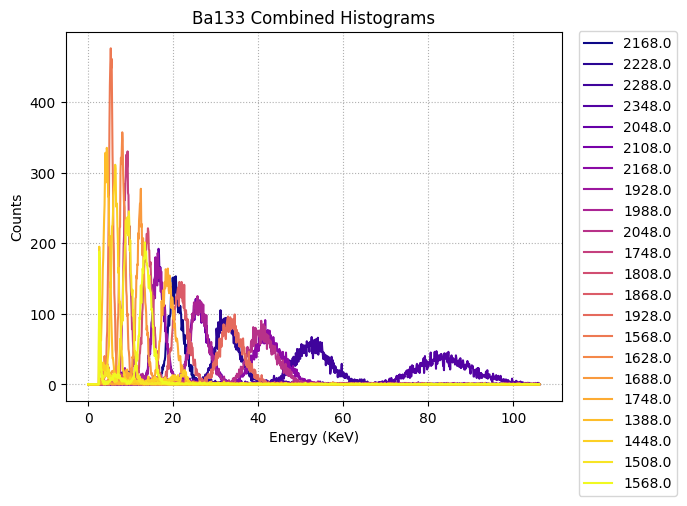

In [297]:
for i in range(0,len(all_data_lists)):
    hist_generator(i,all_data_lists,bkg,file_labels,colour[i],channel_no)
    

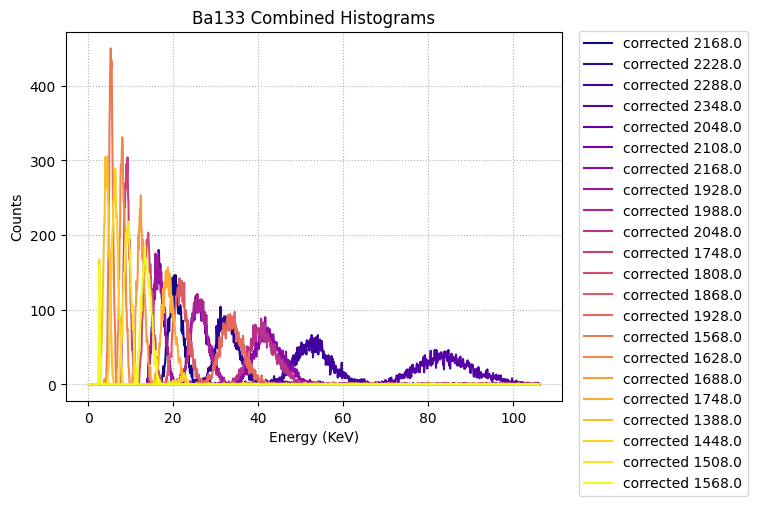

In [298]:
for i in range(0,len(all_data_lists)):
    hist_generator_bkg_corrected(i,all_data_lists,bkg,file_labels,colour[i],channel_no)
    

In [299]:
def charge_cali(channels):
    charge_list=[]
    no_e_list=[]
    e=1.6e-19
    for i in range(0,len(channels)):
        charge= (1.751e-13*channels[i]) + 1.164e-12
        no_e=charge/e
        charge_list.append(charge)
        no_e_list.append(no_e)
    return charge_list, no_e_list

[np.float64(8818466.904323073), np.float64(9456661.098685477), np.float64(10953653.807634952), np.float64(12608552.07281561), np.float64(7839020.129240149), np.float64(8095866.59632298), np.float64(8774999.327032814), np.float64(7504571.015584418), np.float64(7587353.325392218), np.float64(7811040.869221835), np.float64(7335687.090704764), np.float64(7367138.274745156), np.float64(7429461.574293442), np.float64(7483859.365485069), np.float64(7291091.160603515), np.float64(7304745.026263857), np.float64(7322684.037664819), np.float64(7338161.689511126), np.float64(7300567.43354017), np.float64(7286817.199167485), np.float64(7289585.961047191), np.float64(7294294.725917744)]
[np.float64(1111892418.6153152), np.float64(1746254371.0958025), np.float64(2796023088.4547873), np.float64(4437918048.730607), np.float64(452284069.6967893), np.float64(702945490.6086295), np.float64(1129578644.3857093), np.float64(186456688.37334383), np.float64(286629315.9455216), np.float64(442141314.22152686), n

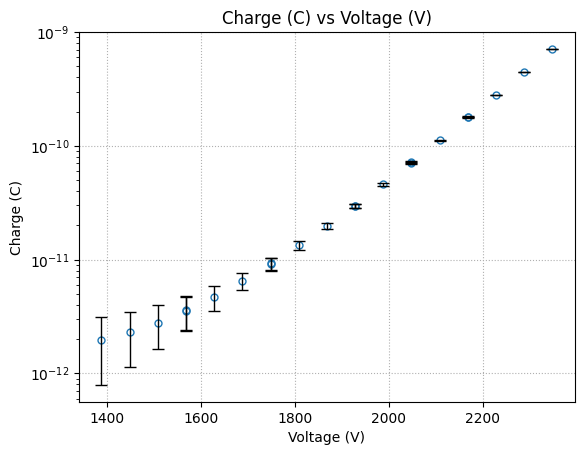

In [300]:

gain_2_10=[0.2]*4
gain_4_10=[0.4]*3
gain_10_10=[1]*3
gain_20_10=[2]*4
gain_40_10=[4]*4
gain_100_10=[10]*4

centroid_gain_corr = (gain_2_10+gain_4_10+gain_10_10+gain_20_10+gain_40_10+gain_100_10)

gain_corr_centroids=[flat_centroids[i]/centroid_gain_corr[i] for i in range(0,len(flat_centroids))]
gain_corr_centroid_errs=[flat_centroid_errors[i]/centroid_gain_corr[i] for i in range(0,len(flat_centroid_errors))]

charge_cali_cents,no_e_list=charge_cali(gain_corr_centroids)
charge_cali_err,no_e_list_err=charge_cali(gain_corr_centroid_errs)
print(no_e_list_err)
plt.plot(file_labels,charge_cali_cents,marker='o',ms=5,linestyle='None',fillstyle='none')
plt.errorbar(file_labels,charge_cali_cents,yerr=charge_cali_err,linestyle='none',color='black', capsize=4, capthick=1,elinewidth=1)
plt.ylabel("Charge (C)")
plt.xlabel("Voltage (V)")
plt.yscale("log")
plt.grid(True, linestyle=':')
plt.title("Charge (C) vs Voltage (V)")
print(no_e_list)
# plt.xlim(1400,1700)
# id1,id2=7,8
# print(file_labels[id1],file_labels[id2])
# print(charge_cali_cents[id1],charge_cali_cents[id2])


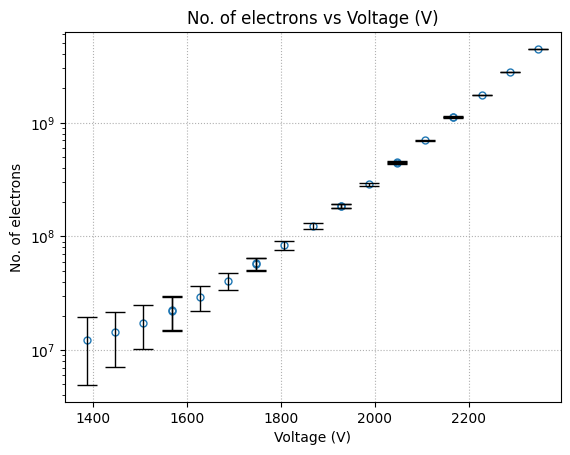

In [301]:
plt.plot(file_labels,no_e_list,marker='o',ms=5,linestyle='None',fillstyle='none')
plt.errorbar(file_labels,no_e_list,yerr=no_e_list_err,linestyle='none',color='black', capsize=7, capthick=1,elinewidth=1)
plt.ylabel("No. of electrons")  
plt.xlabel("Voltage (V)")
plt.yscale("log")
plt.title("No. of electrons vs Voltage (V)")
plt.grid(True, linestyle=':')
plt.show()

In [302]:
def exponential(x,s,t):
    return np.exp((s*x)+t)

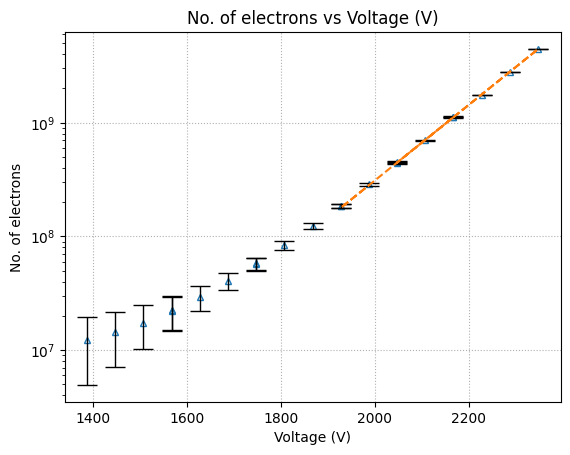

In [303]:
log_no_e_list=np.log(no_e_list)
p0=np.polyfit(file_labels,log_no_e_list,1)
exp_fit=sci.curve_fit(exponential,file_labels,no_e_list,p0=p0)
s,t=exp_fit[0][0],exp_fit[0][1]
fit_exp=[exponential(file_labels[i],s,t) for i in range(0,len(file_labels))]

plt.plot(file_labels,no_e_list,marker='^',ms=5,linestyle='None',fillstyle='none')
plt.errorbar(file_labels,no_e_list,yerr=no_e_list_err,linestyle='none',color='black', capsize=7, capthick=1,elinewidth=1)
plt.plot(file_labels[:-13],fit_exp[:-13],linestyle='--')

plt.ylabel("No. of electrons")
plt.xlabel("Voltage (V)")
plt.yscale("log")
plt.grid(True, linestyle=':')
plt.title("No. of electrons vs Voltage (V)")
plt.show()


In [304]:
def gas_multiplication_factor(charge_cent,No):
    e=1.6e-19
    return [charge_cent[i]/(No*e) for i in range(0,len(charge_cent))]

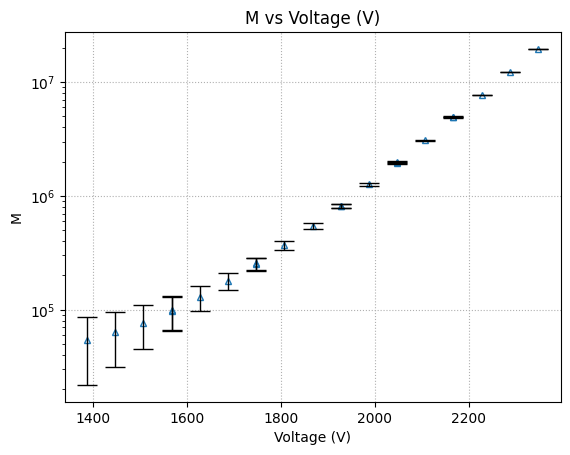

In [305]:
n_o=227
gas_mult_list=gas_multiplication_factor(charge_cali_cents,n_o)
gas_mult_err=gas_multiplication_factor(charge_cali_err,n_o)
plt.plot(file_labels,gas_mult_list,marker='^',ms=5,linestyle='None',fillstyle='none')
plt.errorbar(file_labels,gas_mult_list,yerr=gas_mult_err,linestyle='none',color='black', capsize=7, capthick=1,elinewidth=1)
# plt.plot(file_labels[:-13],fit_exp[:-13],linestyle='--')
plt.ylabel("M")
plt.xlabel("Voltage (V)")
plt.yscale("log")
plt.title("M vs Voltage (V)")
plt.grid(True, linestyle=':')
plt.show()
